# Task2

forecasting_dataset.csv is a file that contains pollution data for a city. Your task is to create a model that, when fed with columns co_gt, nhmc, c6h6, s2, nox, s3, no2, s4, s5, t, rh, ah, and level, predicts the value of y six hours later.

## TOC

1. [Yet to do](#Yet-to-do)
1. [Assumptions](#Assumptions)
2. [Import libraries and data](#Imports)
2. [Feature engineering](#Feature-engineering)
4. [Basic EDA](#EDA)
5. [Feature selection](#Feature-scaling-and-selection)
6. [Linear models and trees](#Modelling)

## Yet to do
1. Remove negative readings and try fitting
2. Overload predict functions from sklearn class to pre-process data
3. Handling edge-cases

## Assumptions
1. No break in 1hour observation of data of the parameters
2. There are 365 rows with negative reading for pollution. Although this seems like an anomaly, ignoring it for the purpose of the analysis due to lack of domain knowledge. *Try removing these observations and predicting*

## Imports

In [126]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from time import time
import pickle

# scikit learn models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet, LinearRegression, RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.externals import joblib

from xgboost import XGBRegressor

%matplotlib inline

In [127]:
fore_data = pd.read_csv('../data/forecasting_dataset.csv', parse_dates=[['date', 'time']])
print(fore_data.shape)
fore_data.head()

(8421, 15)


,date_time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,2004-10-13 20:00:00,943,-200.0,-200.0,7.2,867.0,-200.0,834.0,-200.0,1314.0,891.0,14.8,57.3,0.9603,NaN
1,2004-08-10 03:00:00,919,0.5,-200.0,3.9,704.0,-200.0,861.0,-200.0,1603.0,860.0,24.4,65.0,1.9612,Low
2,2004-06-21 08:00:00,1221,3.7,-200.0,23.3,1386.0,NaN,626.0,109.0,2138.0,NaN,23.3,38.6,1.0919,High
3,2004-07-12 12:00:00,1024,2.1,-200.0,12.1,1052.0,183.0,779.0,NaN,1690.0,952.0,28.5,27.3,1.0479,High
4,2004-12-14 12:00:00,1377,4.4,-200.0,21.7,1342.0,786.0,499.0,206.0,1546.0,2006.0,12.9,54.1,0.8003,High


In [128]:
fore_data.sort_values(['date_time'], inplace=True)
fore_data.reset_index(drop = True).head(6)

,date_time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,2004-03-10 18:00:00,1360,2.6,150.0,11.9,NaN,166.0,1056.0,113.0,1692.0,NaN,13.6,48.9,0.7578,High
1,2004-03-10 19:00:00,1292,2.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,High
2,2004-03-10 20:00:00,1402,2.2,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,NaN,0.7502,NaN
3,2004-03-10 21:00:00,1376,2.2,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,High
4,2004-03-10 22:00:00,1272,1.6,51.0,6.5,836.0,131.0,1205.0,116.0,NaN,1110.0,NaN,59.6,0.7888,High
5,2004-03-10 23:00:00,1197,1.2,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,High


In [129]:
fore_data.describe()

,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah
count,8421.000000,7980.000000,7987.000000,8008.000000,8000.000000,7996.000000,8005.000000,7966.000000,8027.000000,8021.000000,7997.000000,7985.000000,7996.000000
mean,1042.105926,-37.626153,-154.691373,1.134540,898.965250,156.620060,801.763398,50.172483,1414.505295,970.777709,9.904877,38.029105,-7.792764
std,340.287650,80.407058,147.073276,43.563292,350.196842,260.224266,328.978770,129.871132,478.101456,459.593401,44.466069,53.944638,41.250356
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,915.000000,0.500000,-200.000000,4.100000,719.000000,42.000000,647.000000,47.000000,1235.000000,702.000000,11.400000,33.400000,0.727475
50%,1050.000000,1.500000,-200.000000,8.100000,903.000000,128.000000,802.000000,92.000000,1476.000000,939.000000,18.000000,48.100000,1.005100
75%,1220.000000,2.600000,-200.000000,13.900000,1113.000000,269.000000,973.000000,128.000000,1684.000000,1250.000000,24.700000,61.600000,1.338700
max,2040.000000,11.900000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [130]:
fore_data.isnull().sum(axis=0)

date_time      0
y              0
co_gt        441
nhmc         434
c6h6         413
s2           421
nox          425
s3           416
no2          455
s4           394
s5           400
t            424
rh           436
ah           425
level        418
dtype: int64

## Feature engineering

In [131]:
shift_y = fore_data.copy()
shift_y['y_later'] = fore_data.y.shift(-6)
shift_y.reset_index(drop = True, inplace = True)
fore_data = shift_y.copy()
fore_data.head(10)

,date_time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level,y_later
0,2004-03-10 18:00:00,1360,2.6,150.0,11.9,NaN,166.0,1056.0,113.0,1692.0,NaN,13.6,48.9,0.7578,High,1185.0
1,2004-03-10 19:00:00,1292,2.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,High,1136.0
2,2004-03-10 20:00:00,1402,2.2,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,NaN,0.7502,NaN,1094.0
3,2004-03-10 21:00:00,1376,2.2,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,High,1010.0
4,2004-03-10 22:00:00,1272,1.6,51.0,6.5,836.0,131.0,1205.0,116.0,NaN,1110.0,NaN,59.6,0.7888,High,1011.0
5,2004-03-10 23:00:00,1197,1.2,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,High,1066.0
6,2004-03-11 00:00:00,1185,1.2,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,High,1052.0
7,2004-03-11 01:00:00,1136,NaN,31.0,3.3,672.0,NaN,1453.0,76.0,1333.0,730.0,10.7,60.0,NaN,Moderate,1144.0
8,2004-03-11 02:00:00,1094,0.9,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,Low,1333.0
9,2004-03-11 03:00:00,1010,0.6,19.0,1.7,561.0,-200.0,1705.0,-200.0,1235.0,501.0,10.3,60.2,0.7517,Low,1351.0


In [132]:
# removing last 6 rows as there are no 6 hour ahead forecast
fore_data = fore_data.head(-6)

In [133]:
depen_cols = ['y','y_later']

In [134]:
numeric_cols = list(fore_data.select_dtypes(include=[np.number]).columns)

In [135]:
num_features = list(set(numeric_cols).difference(depen_cols))

In [136]:
fore_data.loc[:,num_features] = fore_data.loc[:,num_features].apply(lambda x: x.fillna(x.mean()).astype("float"),
                                                                    axis=0)

In [137]:
fore_data['level'].fillna(fore_data['level'].mode()[0],
                         inplace=True)
fore_data.isnull().sum(axis=0)

date_time    0
y            0
co_gt        0
nhmc         0
c6h6         0
s2           0
nox          0
s3           0
no2          0
s4           0
s5           0
t            0
rh           0
ah           0
level        0
y_later      0
dtype: int64

In [138]:
fore_data = pd.concat([fore_data.drop(['level'],axis = 1),
          pd.get_dummies(fore_data.level,prefix = 'level')],
          axis = 1,
         )

fore_data.columns = ["".join(s.split()) for s in fore_data.columns] #remove all whitespace in string

In [139]:
cat_features = [s for s in fore_data.columns if "level" in s]

## EDA

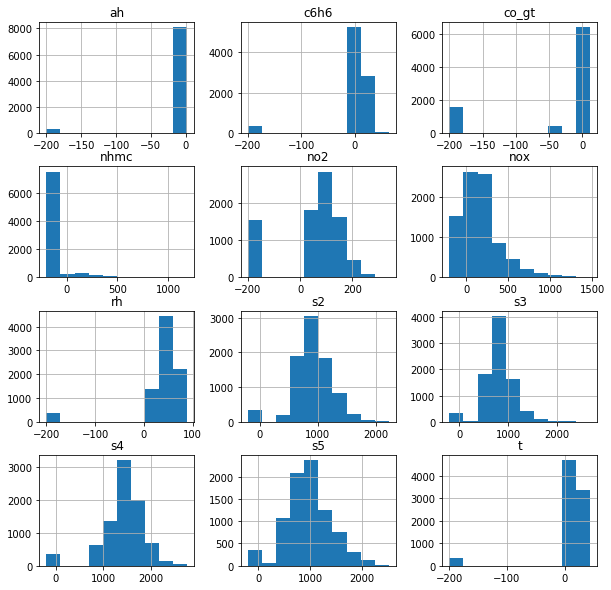

In [140]:
#dist of features
fore_data.loc[:,num_features].hist(figsize = (10,10))
plt.show()

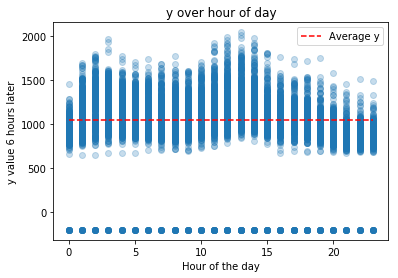

In [141]:
plt.scatter(fore_data.date_time.dt.hour.values,
            fore_data.y_later.values,
            marker='o', 
            alpha = 0.25)
plt.plot((0,fore_data.date_time.dt.hour.values.max()),
         (fore_data.y_later.values.mean(),fore_data.y_later.values.mean()), 
         'r--', 
         label='Average y')
plt.xlabel("Hour of the day")
plt.ylabel("y value 6 hours later")
plt.title('y over hour of day')
plt.legend()
plt.show()

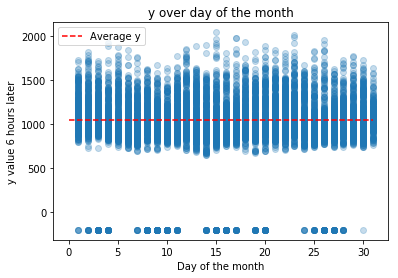

In [142]:
plt.scatter(fore_data.date_time.dt.day.values,
            fore_data.y_later.values,
            marker='o', 
            alpha = 0.25)
plt.plot((0,fore_data.date_time.dt.day.values.max()),
         (fore_data.y_later.values.mean(),fore_data.y_later.values.mean()), 
         'r--', 
         label='Average y')
plt.xlabel("Day of the month")
plt.ylabel("y value 6 hours later")
plt.title('y over day of the month')
plt.legend()
plt.show()

Text(0.5,1,'Distribution of pollution data')

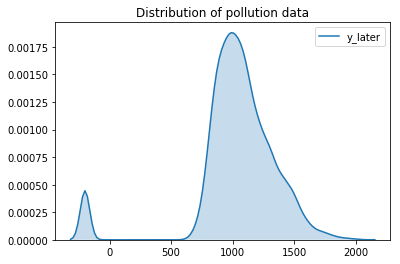

In [143]:
(sns.kdeplot(fore_data['y_later'], shade=True)
   .set_title("Distribution of pollution data")
)

In [144]:
print("Rows with negative readings",fore_data[fore_data.y_later < 0].shape[0])

Rows with negative readings 365


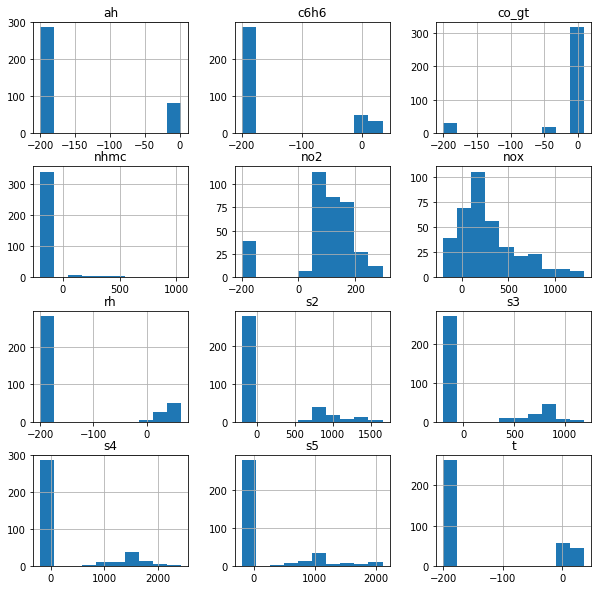

In [145]:
# dist of features for negative y-values
fore_data[fore_data.y_later < 0].loc[:,num_features].hist(figsize = (10,10))
plt.show()

Text(0.5,1,'Pairwise correlation')

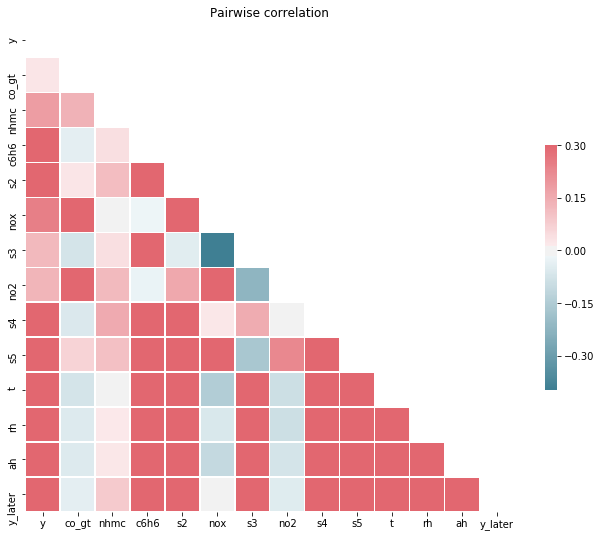

In [146]:
# source for code: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
d = fore_data.loc[:,numeric_cols]
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Pairwise correlation')

In [147]:
fore_data.to_csv('../results/processed_task2.csv')

## Assumptions
1. Assuming -200 values are valid in this case. Do not have enough knowledge to classify them as anomalies

## Feature scaling and selection

In [148]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    fore_data.drop(['date_time','y','y_later'], axis = 1),
                                                    fore_data.y,
                                                    test_size=0.20)

In [149]:
num_features

['nhmc',
 's3',
 'no2',
 's2',
 's4',
 'ah',
 'nox',
 't',
 'rh',
 'c6h6',
 's5',
 'co_gt']

In [150]:
# X_train=X_train.values
X_std=np.asarray(X_train.loc[:,num_features])

# Finding normalised array of X_Train
std = StandardScaler()
X_std=std.fit_transform(X_std)

In [151]:
joblib.dump(std, '../models/task2_scaler.pkl') 

['../models/task2_scaler.pkl']

In [152]:
X_std.shape

(6732, 12)

Text(0.5,1,'Variance explained vs components')

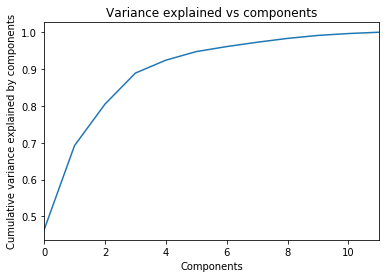

In [153]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,11,1)
plt.xlabel('Components')
plt.ylabel('Cumulative variance explained by components')
plt.title('Variance explained vs components')

**We can explain close to 90% of the variance in the model with 3 components**

In [154]:
pca = PCA(n_components=5)
X_pca_std = pca.fit_transform(X_std)
X_pca_std = pd.DataFrame(X_pca_std, columns = ['comp_' + str(i + 1) for i in range(X_pca_std.shape[1])])
X_tr = pd.concat([X_pca_std,
                   X_train.loc[:,cat_features].reset_index(drop = True)
                 ], axis = 1
                )
X_tr.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,level_High,level_Low,level_Moderate,level_VeryHigh,level_Verylow
0,-0.292513,-2.597205,1.801381,0.005110,0.307880,0,0,0,0,1
1,-2.043551,2.058216,1.082973,-0.230449,-0.746004,1,0,0,0,0
2,-0.443314,-0.050689,-0.505732,0.036127,-0.401788,1,0,0,0,0
3,0.672258,-0.008864,-1.309956,-0.532115,0.280831,0,1,0,0,0
4,-0.581949,0.570511,-0.030324,-0.383751,-0.371781,1,0,0,0,0


In [155]:
joblib.dump(pca, '../models/task2_PCA.pkl') 

['../models/task2_PCA.pkl']

## Modelling

In [156]:
# define function to compute adjusted R^2
def report_adjR2(model, X, y, Xv, yv):
    N = X.shape[0]
    d_f = X.shape[1]
    adjR2 = lambda y, yhat: 1.0 - (N-1.0)/(N-d_f-1.0) * np.mean((y-yhat)**2)/np.var(y)
    score = [adjR2(y, model.predict(X)),adjR2(yv, model.predict(Xv))]
    return score

In [157]:
models = {
    'Ridge Regression': Ridge(alpha = 0.1),
    'Lasso Regression': Lasso(alpha = 0.1),
    'Bayesian Regression': BayesianRidge(),
    'Elastic Net': ElasticNet(alpha = 0.01, l1_ratio = 0.5),
    'RANSAV': RANSACRegressor(),
    'Linear regression': LinearRegression(), 
    'Gradient boosting': GradientBoostingRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=10, max_depth=20, 
                               criterion='mse', 
                               random_state=1234, 
                               n_jobs=-1),
    'xgboost regressor': XGBRegressor(),
    'Bagging regressor': BaggingRegressor(n_estimators=10)
}

In [158]:
X_test_std = std.transform(X_test.loc[:,num_features])
# print(X_test_std)

X_test_std = pca.transform(X_test_std)

X_test_std = pd.DataFrame(X_test_std, columns = ['comp_' + str(i + 1) for i in range(X_test_std.shape[1])])
X_test_std = pd.concat([X_test_std,
                   X_test.loc[:,cat_features].reset_index(drop = True)
                 ], axis = 1
                )
X_test_std.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,level_High,level_Low,level_Moderate,level_VeryHigh,level_Verylow
0,-0.647679,0.524932,-0.017018,-0.360859,-0.463906,1,0,0,0,0
1,0.958281,-0.578719,-1.505909,-0.556518,0.728279,0,0,1,0,0
2,-0.930778,1.448245,0.534173,-0.444277,-0.232993,1,0,0,0,0
3,0.644815,-0.463758,-1.458763,-0.466374,0.188227,0,0,1,0,0
4,10.229953,1.806257,2.041172,0.395937,-0.996709,1,0,0,0,0


In [159]:
import collections
X_tr = X_tr[sorted(X_tr.columns)].values
X_test_std = X_test_std[sorted(X_test_std.columns)].values

r2s = collections.defaultdict(dict)
t0 = time()
for name, model in models.items():
    model.fit(X_tr,y_train)

    r2s[name]['r2_train'] = r2_score(model.predict(X_tr), y_train)
    r2s[name]['r2_test'] = r2_score(model.predict(X_test_std), y_test)
    
    r2s[name]['adj_r2_train'] = report_adjR2(model, X_tr, y_train, X_tr, y_train)[1]
    r2s[name]['adj_r2_test'] = report_adjR2(model, X_tr, y_train, X_test_std, y_test)[1]
    
    r2s[name]['mse_train'] = mean_squared_error(y_train,model.predict(X_tr))
    r2s[name]['mse_test'] = mean_squared_error(y_test,model.predict(X_test_std))
    
    print('Completed predicting for {} model'.format(name))
    
print('Completed prediction in {:.2f} seconds'.format(time() - t0))

Completed predicting for Ridge Regression model
Completed predicting for Lasso Regression model
Completed predicting for Bayesian Regression model
Completed predicting for Elastic Net model
Completed predicting for RANSAV model
Completed predicting for Linear regression model
Completed predicting for Gradient boosting model
Completed predicting for Random Forest model
Completed predicting for xgboost regressor model
Completed predicting for Bagging regressor model
Completed prediction in 6.37 seconds


In [160]:
pd.DataFrame(r2s)

,Bagging regressor,Bayesian Regression,Elastic Net,Gradient boosting,Lasso Regression,Linear regression,RANSAV,Random Forest,Ridge Regression,xgboost regressor
adj_r2_test,0.958063,0.946382,0.946406,0.957014,0.946425,0.946354,0.915455,0.957263,0.946356,0.957041
adj_r2_train,0.991463,0.937415,0.937309,0.956283,0.937341,0.937417,0.906236,0.990959,0.937417,0.955760
mse_test,5238.551949,6697.761296,6694.737904,5369.642041,6692.418274,6701.275728,10561.023258,5338.527634,6701.026627,5366.284076
mse_train,967.862438,7095.070618,7107.027168,4955.999590,7103.376421,7094.750013,10629.711889,1024.916807,7094.751305,5015.280145
r2_test,0.956110,0.943544,0.943460,0.954222,0.943582,0.943518,0.913598,0.955482,0.943520,0.954176
r2_train,0.991239,0.933330,0.933050,0.953859,0.933210,0.933345,0.902724,0.990766,0.933344,0.953209


In [161]:
joblib.dump(models['xgboost regressor'], '../models/task2_model.pkl') 

['../models/task2_model.pkl']

## Predict class testing

In [1]:
from Task2 import XGBoostWrapper

In [2]:
t2 = XGBoostWrapper()

In [3]:
import pandas as pd
dummy_data = pd.read_csv('../data/forecasting_dataset.csv', parse_dates=[['date', 'time']]).sample(10)
dt = dummy_data.dropna().drop(['date_time','y'],axis = 1)
t2.predict(dt)

Creating one-hot encoding vector for operational setting 3 column
level_High
level_Low
level_Moderate
level_VeryHigh
level_Verylow
Index(['co_gt', 'nhmc', 'c6h6', 's2', 'nox', 's3', 'no2', 's4', 's5', 't',
       'rh', 'ah', 'level_High', 'level_Low', 'level_Very low',
       'level_Moderate', 'level_VeryHigh', 'level_Verylow'],
      dtype='object')


array([ 1382.12072754,  1392.89257812,  1476.04345703,  1387.80554199,
        1377.32202148,  1403.39306641], dtype=float32)